# Importing emissions files

This notebook example shows how to run FaIR with your own emissions scenarios. This feature was introduced in fair v2.2.0.

The data is in the `examples/data/importing-data` directory of the fair repository.

The structure of this example closely follows the `basic-run-example`.

In [1]:
import pandas as pd
from fair import FAIR
from fair.io import read_properties
from fair.interface import fill, initialise

import matplotlib.pyplot as pl

In [2]:
f = FAIR()

## Set up the run

In [3]:
f.define_time(2000, 2050, 1)  # annual timestep, running from 2000 to 2050
f.define_scenarios(["renewable", "fossil"])  # define two emissions scenarios
f.define_configs(["one", "two", "three"])  # three climate ensemble members

In this example the `species_configs_properties` are read in from an external file.

`species_configs_properties` contains the list of species that you want to run with, how you want to run them, and the default (though modifiable) parameter values that you give them.

In [4]:
species, properties = read_properties("data/importing-data/species_configs_properties.csv")

In [5]:
species

['CO2 FFI',
 'CO2 AFOLU',
 'CO2',
 'CH4',
 'N2O',
 'Sulfur',
 'Volcanic',
 'Aerosol-radiation interactions',
 'Aerosol-cloud interactions']

In [6]:
f.define_species(species, properties)

In [7]:
f.allocate()

## Read in our driving data

First, we'll inspect it using `pandas`.

Note that not every `specie` defined is included here, since some are calculated from other species (CO2, aerosol-radiation and aerosol-cloud forcing).

Remember also that emissions are on `timepoints` - so will be calculated on half years.

The `fill_from_csv` function will do our interpolation for us, so it's fine to provide 10-year data for an annual problem.

In [8]:
pd.read_csv('data/importing-data/demo-emissions.csv')

,Model,Scenario,Region,Variable,Unit,2000,2010,2020,2030,2040,2050
0,demo,renewable,World,CO2 FFI,Gt CO2/yr,30,35,37,28,23,14
1,demo,renewable,World,CO2 AFOLU,Gt CO2/yr,3,4,3,1,-1,-3
2,demo,renewable,World,Sulfur,Mt SO2/yr,100,95,80,65,50,38
3,demo,fossil,World,CO2 FFI,Gt CO2/yr,30,35,37,45,50,55
4,demo,fossil,World,CO2 AFOLU,Gt CO2/yr,3,4,3,1,-1,-3
5,demo,fossil,World,Sulfur,Mt SO2/yr,100,95,80,70,60,50


In [9]:
pd.read_csv('data/importing-data/demo-concentration.csv')

,Model,Scenario,Region,Variable,Unit,2000,2010,2020,2030,2040,2050
0,demo,renewable,World,CH4,ppb,1600,1700,1900,1700,1600,1500
1,demo,renewable,World,N2O,ppb,315,325,335,344,353,361
2,demo,fossil,World,CH4,ppb,1600,1700,1900,2100,2300,2500
3,demo,fossil,World,N2O,ppb,315,325,335,345,355,365


In [10]:
pd.read_csv('data/importing-data/demo-forcing.csv')

,Model,Scenario,Region,Variable,Unit,2000,2010,2020,2030,2040,2050
0,demo,renewable,World,Volcanic,W/m2,-0.2,-0.2,-0.1,0,0,0
1,demo,fossil,World,Volcanic,W/m2,-0.2,-0.2,-0.1,0,0,0


In [11]:
f.fill_from_csv(
    emissions_file='data/importing-data/demo-emissions.csv',
    concentration_file='data/importing-data/demo-concentration.csv',
    forcing_file='data/importing-data/demo-forcing.csv'
)

## Now we fill in the climate and species configs

First take the defaults from the same file as the species/properties definition:

In [12]:
f.fill_species_configs('data/importing-data/species_configs_properties.csv')

Then, for each config set (climate ensemble member) we want to **override** to the default values in the `species_config_default` file. Note that no climate configs are given by default because we want users to think about what they are doing.

In [13]:
df_configs = pd.read_csv('data/importing-data/calibrated_constrained_parameters.csv', index_col=0)

In [14]:
energy_balance_parameters = [
    'gamma_autocorrelation',
    'ocean_heat_capacity',
    'ocean_heat_transfer',
    'deep_ocean_efficacy',
    'sigma_eta',
    'sigma_xi',
    'forcing_4co2',
    'seed',
    'use_seed',
    'stochastic_run'
]

In [15]:
f.climate_configs

<xarray.Dataset> Size: 366B
Dimensions:                (config: 3, layer: 3)
Coordinates:
  * config                 (config) <U5 60B 'one' 'two' 'three'
  * layer                  (layer) int64 24B 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 72B nan nan nan ... nan nan
    ocean_heat_capacity    (config, layer) float64 72B nan nan nan ... nan nan
    deep_ocean_efficacy    (config) float64 24B nan nan nan
    stochastic_run         (config) bool 3B False False False
    sigma_eta              (config) float64 24B 0.5 0.5 0.5
    sigma_xi               (config) float64 24B 0.5 0.5 0.5
    gamma_autocorrelation  (config) float64 24B 2.0 2.0 2.0
    seed                   (config) uint32 12B 0 0 0
    use_seed               (config) bool 3B False False False
    forcing_4co2           (config) float64 24B 8.0 8.0 8.0

In [16]:
for config in f.configs:
    for col in df_configs.columns:
        if len(col.split("[")) > 1:
            param_name = col.split("[")[0]
            param_index = (col.split("[")[1][:-1])
        else:
            param_name = col
            param_index = None

        if param_name in energy_balance_parameters:
            if param_index is not None:
                fill(f.climate_configs[param_name], df_configs.loc[config, col], layer=int(param_index), config=config)
            else:
                fill(f.climate_configs[param_name], df_configs.loc[config, col], config=config)

        else:
            if param_index is not None:
                fill(f.species_configs[param_name], df_configs.loc[config, col], specie=param_index, config=config)
            else:
                fill(f.species_configs[param_name], df_configs.loc[config, col], config=config)

In [17]:
fill(f.climate_configs['stochastic_run'], True)

## Initial conditions

What do we assume at the first time bound (2000.0)?

In [18]:
initialise(f.concentration, 278, specie='CO2')
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)

## Run

In [19]:
f.run()

Running 6 projections in parallel:   0%|          | 0/50 [00:00<?, ?timesteps/s]

## Analyse results

In [20]:
f.temperature

<xarray.DataArray (timebounds: 51, scenario: 2, config: 3, layer: 3)> Size: 7kB
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]],


       [[[ 5.05741263e-03, -3.16360882e-04, -3.88894613e-06],
         [-4.33693360e-02,  4.58687510e-03,  5.63160450e-05],
         [-1.56370292e-01, -1.27773218e-02, -6.26308925e-05]],

        [[ 5.05741263e-03, -3.16360882e-04, -3.88894613e-06],
         [-4.33693360e-02,  4.58687510e-03,  5.63160450e-05],
         [-1.56370292e-01, -1.27773218e-02, -6.26308925e-05]]],


       [[[-6.67467833e-02, -7.74227692e-04, -3.97659375e-06],
         [-4.26082947e-02, -1.73767224e-03,  7.39891966e-05],
...
         [ 9.44189878e-01,  5.90166623e-01,  1.32821008e-01],
         [ 1.10453556e+00,  6.31689472e-01,  3.37934297e-02]]],


       [[[ 8.16595314e-01,  4.46169982e-01,  1.06460522e-01],
         [ 7.08300625e-01,  4.45390839e-01,  1.20372921e-01],
         [ 7.28500940e-01,  4.26186012e-01,  1.16823556e-02]],

        [[ 1.18837015e+00,  5.63467383e-01,  1.19127454e-01],
         [ 9.98813409e-01,  6.04269545e-01,  1.38254987e-01],
         [ 1.14410086e+00,  6.62564616e-01,  4.31094904e-02]]],


       [[[ 9.84338838e-01,  4.51493442e-01,  1.10634020e-01],
         [ 5.65595472e-01,  4.34172926e-01,  1.24152364e-01],
         [ 6.17471784e-01,  4.30102605e-01,  1.80252968e-02]],

        [[ 1.37647409e+00,  5.76926755e-01,  1.24629518e-01],
         [ 8.72359405e-01,  6.03000272e-01,  1.43751653e-01],
         [ 1.05974450e+00,  6.83351824e-01,  5.26890133e-02]]]])
Coordinates:
  * timebounds  (timebounds) float64 408B 2e+03 2.001e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U9 72B 'renewable' 'fossil'
  * config      (config) <U5 60B 'one' 'two' 'three'
  * layer       (layer) int64 24B 0 1 2

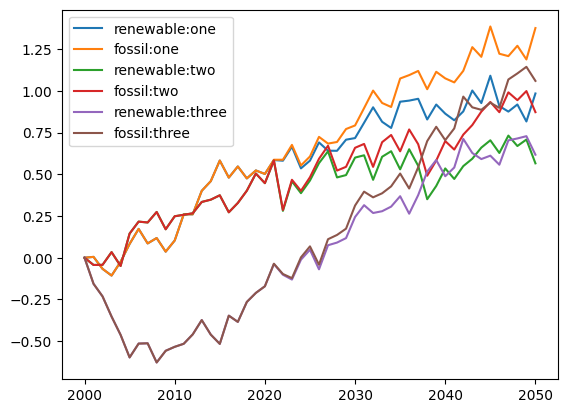

In [21]:
for config in f.configs:
    for scenario in f.scenarios:
        pl.plot(f.timebounds, f.temperature.sel(layer=0, scenario=scenario, config=config), label=f"{scenario}:{config}");
pl.legend()

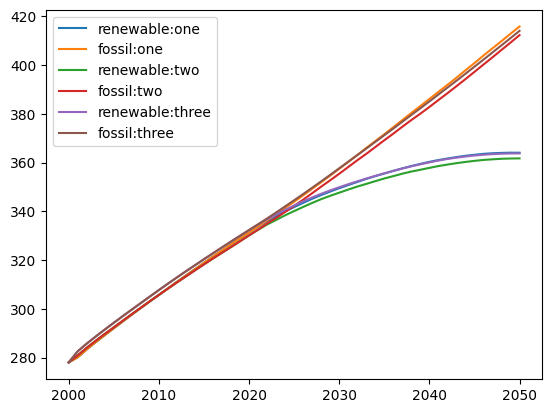

In [22]:
for config in f.configs:
    for scenario in f.scenarios:
        pl.plot(f.timebounds, f.concentration.sel(scenario=scenario, config=config, specie="CO2"), label=f"{scenario}:{config}");
pl.legend()

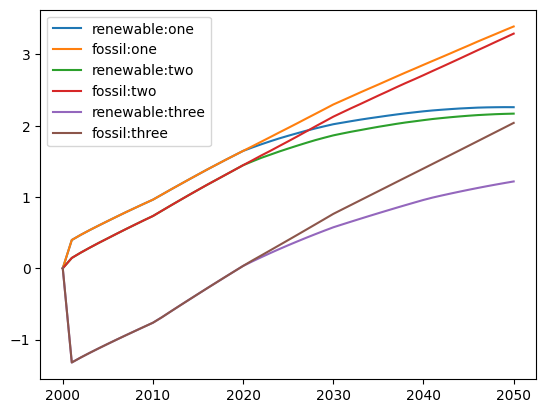

In [23]:
for config in f.configs:
    for scenario in f.scenarios:
        pl.plot(f.timebounds, f.forcing_sum.sel(scenario=scenario, config=config), label=f"{scenario}:{config}");
pl.legend()